In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('baseball_teams.csv')

# Objectives

Business Objectives

The primary business objective of this project is to identify what variables have the strongest influence on team success in baseball thorughout the years and how these variables can be used to imporve outcomes. Decision makers at all levels, i.e, analysts, coaches, and general managers, need knowledge about what areas of the game drive performance in order to improve. Throughout the report, the goal is to determine what data driven variables are needed to improve team competitiveness and who to allocate resources to.

Analytical Objectives

The primary analytical objective of the project is to apply linear regression modelling to add value to performance metrics and how those metrics relate to winning games. This involves identify the strongest predictors, assessing the accuracy of the model, and finally, ensuring the the model assumptions are met. Throughout the report, the goal is to deliver accurate results that can be useful for decision makers.

# Data Exploration

Preliminary Analysis

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
missing_percent = numeric_df.isnull().mean() * 100
print(missing_percent)

Year                    0.000000
Final_Standing          0.000000
Games_Played            0.000000
Unnamed: 7             14.224599
Games_Won               0.000000
Games_Lost              0.000000
Runs_Scored             0.000000
At_Bats                 0.000000
Hits                    0.000000
Doubles                 0.000000
Triples                 0.000000
Home_Runs               0.000000
Walks                   0.000000
Strike_Outs             4.278075
Stolen_Bases            5.133690
Caught_Stealing        30.623886
Hit_By_Pitch           82.887701
Sacrifice_Fly          82.887701
Runs_Against            0.000000
Earned_Runs             0.000000
Earned_Run_Average      0.000000
Complete_Games          0.000000
Shutout                 0.000000
Saves                   0.000000
Infield_Put_Outs        0.000000
Hits_Allowed            0.000000
Home_Run_Allowed        0.000000
Walks_Allowed           0.000000
Strikeouts_Allowed      0.000000
Errors                  0.000000
Double_Pla

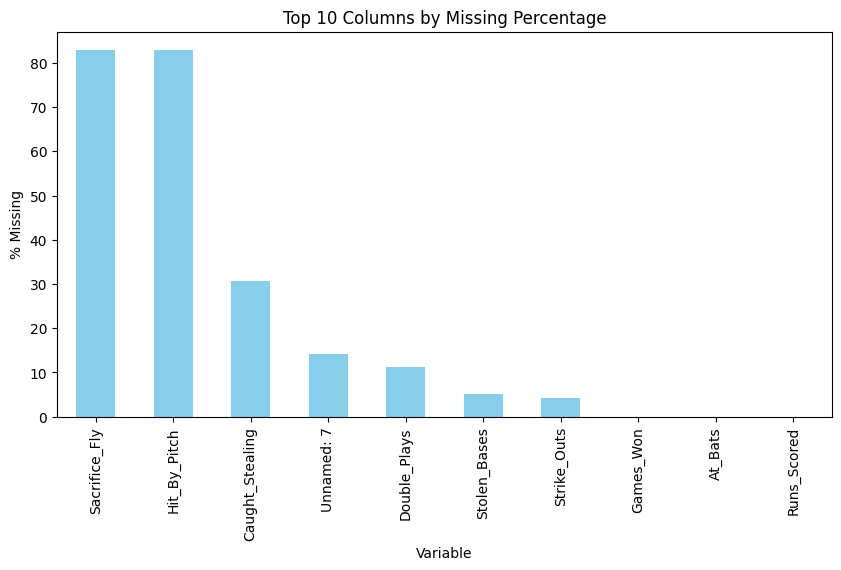

In [ ]:
plt.figure(figsize=(10, 5))
missing_percent.sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Columns by Missing Percentage")
plt.ylabel("% Missing")
plt.xlabel("Variable")
plt.show()

From this table we can see that the hit by pitch and sacrifice fly metrics are missing over 80% of their values. However, metrics like games won, at bats, and runs scored (Important metrics) are complete. Despite the missing data in some metrics, there is sufficient enough data quality to warrant further analysis

In [ ]:
print("Data Types")
print(numeric_df.dtypes.value_counts())

Data Types
int64      23
float64     9
Name: count, dtype: int64


In [ ]:
normality_results = {}
for col in numeric_df.columns:
    data = numeric_df[col].dropna()
    if len(data) > 5000:
        data = data.sample(5000, random_state=42)
    stat, p = shapiro(data)
    normality_results[col] = "Normal" if p > 0.05 else "Not Normal"

print(normality_results)

{'Year': 'Not Normal', 'Final_Standing': 'Not Normal', 'Games_Played': 'Not Normal', 'Unnamed: 7': 'Not Normal', 'Games_Won': 'Not Normal', 'Games_Lost': 'Not Normal', 'Runs_Scored': 'Not Normal', 'At_Bats': 'Not Normal', 'Hits': 'Not Normal', 'Doubles': 'Not Normal', 'Triples': 'Not Normal', 'Home_Runs': 'Not Normal', 'Walks': 'Not Normal', 'Strike_Outs': 'Not Normal', 'Stolen_Bases': 'Not Normal', 'Caught_Stealing': 'Not Normal', 'Hit_By_Pitch': 'Not Normal', 'Sacrifice_Fly': 'Not Normal', 'Runs_Against': 'Not Normal', 'Earned_Runs': 'Not Normal', 'Earned_Run_Average': 'Not Normal', 'Complete_Games': 'Not Normal', 'Shutout': 'Not Normal', 'Saves': 'Not Normal', 'Infield_Put_Outs': 'Not Normal', 'Hits_Allowed': 'Not Normal', 'Home_Run_Allowed': 'Not Normal', 'Walks_Allowed': 'Not Normal', 'Strikeouts_Allowed': 'Not Normal', 'Errors': 'Not Normal', 'Double_Plays': 'Not Normal', 'Fielding_Percentage': 'Not Normal'}


There are no normally distributed variables  

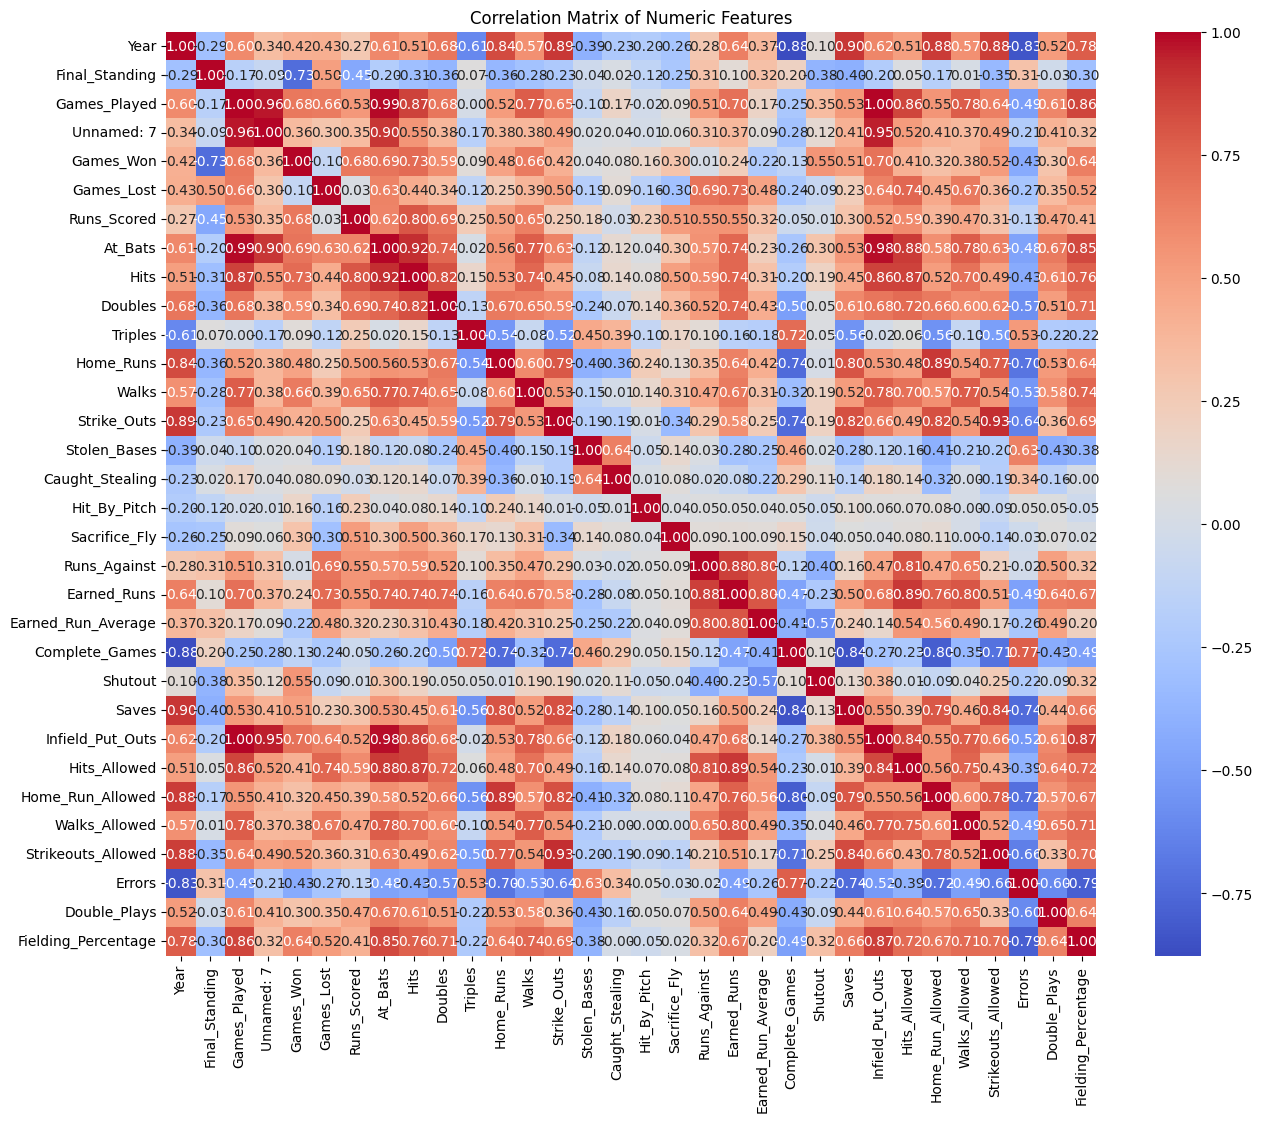

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

There are several variables that are strongly correlated with each other, for example, games played and at bats

The purpose of this data exploration was to understand variable distributions and identify potential issues before modelling. Through exploration, we were able to find variables that became useless due to either missing values or variables using text instead of values. We were also able to see an early sign of which data variables are closely correlated to each other.  

# Correlation Analysis

In [ ]:
correlations = numeric_df.corrwith(numeric_df['Games_Won']).sort_values(ascending = False)
print(correlations)

Games_Won              1.000000
Hits                   0.725160
Infield_Put_Outs       0.697276
At_Bats                0.689233
Runs_Scored            0.677243
Games_Played           0.676371
Walks                  0.655929
Fielding_Percentage    0.644387
Doubles                0.586949
Shutout                0.545568
Strikeouts_Allowed     0.518630
Saves                  0.505623
Home_Runs              0.484075
Strike_Outs            0.419930
Year                   0.418790
Hits_Allowed           0.413214
Walks_Allowed          0.380921
Unnamed: 7             0.358841
Home_Run_Allowed       0.320302
Double_Plays           0.302562
Sacrifice_Fly          0.298843
Earned_Runs            0.235721
Hit_By_Pitch           0.161396
Triples                0.086865
Caught_Stealing        0.078767
Stolen_Bases           0.043120
Runs_Against           0.006238
Games_Lost            -0.102111
Complete_Games        -0.134360
Earned_Run_Average    -0.220270
Errors                -0.430352
Final_St

Throughout all the time periods, the variables most correlated with games won are hits, infield put outs, at bats, runs scored, games played, walks, fielding percentage, and doubles

Style of Play Through the 4 Periods

In [ ]:
df['Period'] = pd.qcut(df['Year'], 4, labels = ["Period 1", "Period 2", "Period 3", "Period 4"])
period4 = df[df['Period'] == "Period 4"]

In [ ]:
summary_results = {}
for period in df['Period'].unique():
    period_data = df[df['Period'] == period]
    corr_matrix = period_data.corr(numeric_only=True)

    corr_with_wins = corr_matrix['Games_Won'].sort_values(ascending=False).dropna()

    period_top_corrs = corr_with_wins.drop(labels=['Games_Won'], errors='ignore').head(10)
    summary_results[period] = period_top_corrs

In [ ]:
print(summary_results)

{'Period 1': Caught_Stealing        0.883660
Hits                   0.808361
Infield_Put_Outs       0.779830
At_Bats                0.775265
Games_Played           0.765999
Fielding_Percentage    0.752685
Doubles                0.749308
Walks                  0.712184
Strikeouts_Allowed     0.695112
Runs_Scored            0.681313
Name: Games_Won, dtype: float64, 'Period 2': Runs_Scored            0.626908
Shutout                0.532723
Saves                  0.409693
Hits                   0.406566
Home_Runs              0.349629
Infield_Put_Outs       0.345626
Walks                  0.335050
Fielding_Percentage    0.334031
Strikeouts_Allowed     0.303460
Complete_Games         0.300306
Name: Games_Won, dtype: float64, 'Period 3': Runs_Scored         0.669857
Hits                0.569340
Saves               0.490461
Infield_Put_Outs    0.478612
At_Bats             0.466848
Walks               0.440459
Shutout             0.433923
Games_Played        0.427632
Unnamed: 7          0.417

In period 1, the most correlated variables are caught stealing, hits, infield put outs, at bats, games played, fielding percentage, doubles, walks, strikeouts allowed, and runs scored. With 2 out of those top variables being neither positive offensive or defensive variables (games played and caught stealing), this period is balanced with 5 offensive variables and 3 defensive variables.  

In period 2, the top 8 most correlated variables are runs scored, shutout, saves, hits, home runs, infield put outs, walks, and fielding percentages. With 4 offensive variables and 4 defensive variables, this period is balanced.

In period 3, the most correlated variables are runs scored, hits, saves, infield put outs, at bats, walks, shutouts, games played, unnamed, and home runs. With two out of the ten variables being neither offensive or defensive variables (games played, and unnamed), this period is balanced with 5 offensive and 3 defensive varibles.

In period 4, the top 8 most correlated variables are saves, runs scored, shutouts, hits, strikeouts allowed, walks, infield putouts, and home runs. With 4 offensive and 4 defensive variables, this period is balanced.

# Linear Regression Models

Exploritory Data Analysis for Period 4

In [ ]:
top8_vars_period_4 = summary_results['Period 4'][['Saves', 'Runs_Scored', 'Shutout', 'Hits', 'Strikeouts_Allowed', 'Walks', 'Infield_Put_Outs', 'Home_Runs']]

In [ ]:
desc_stats = period4[top8_vars_period_4.index].describe()
display(desc_stats)

,Saves,Runs_Scored,Shutout,Hits,Strikeouts_Allowed,Walks,Infield_Put_Outs,Home_Runs
count,680.000000,680.000000,680.000000,680.000000,680.00000,680.000000,680.000000,680.000000
mean,40.177941,740.545588,8.614706,1436.182353,1072.52500,525.450000,4264.692647,164.138235
std,7.681574,93.754188,4.073886,116.056734,150.11375,78.052985,269.787520,35.129196
min,20.000000,466.000000,0.000000,963.000000,560.00000,319.000000,2952.000000,80.000000
25%,35.000000,677.500000,6.000000,1381.750000,980.00000,471.750000,4302.000000,139.000000
50%,40.000000,738.000000,8.000000,1446.500000,1070.00000,522.500000,4331.000000,161.000000
75%,45.000000,801.000000,11.000000,1508.000000,1174.50000,576.250000,4359.000000,187.000000
max,66.000000,1009.000000,23.000000,1684.000000,1450.00000,775.000000,4485.000000,264.000000


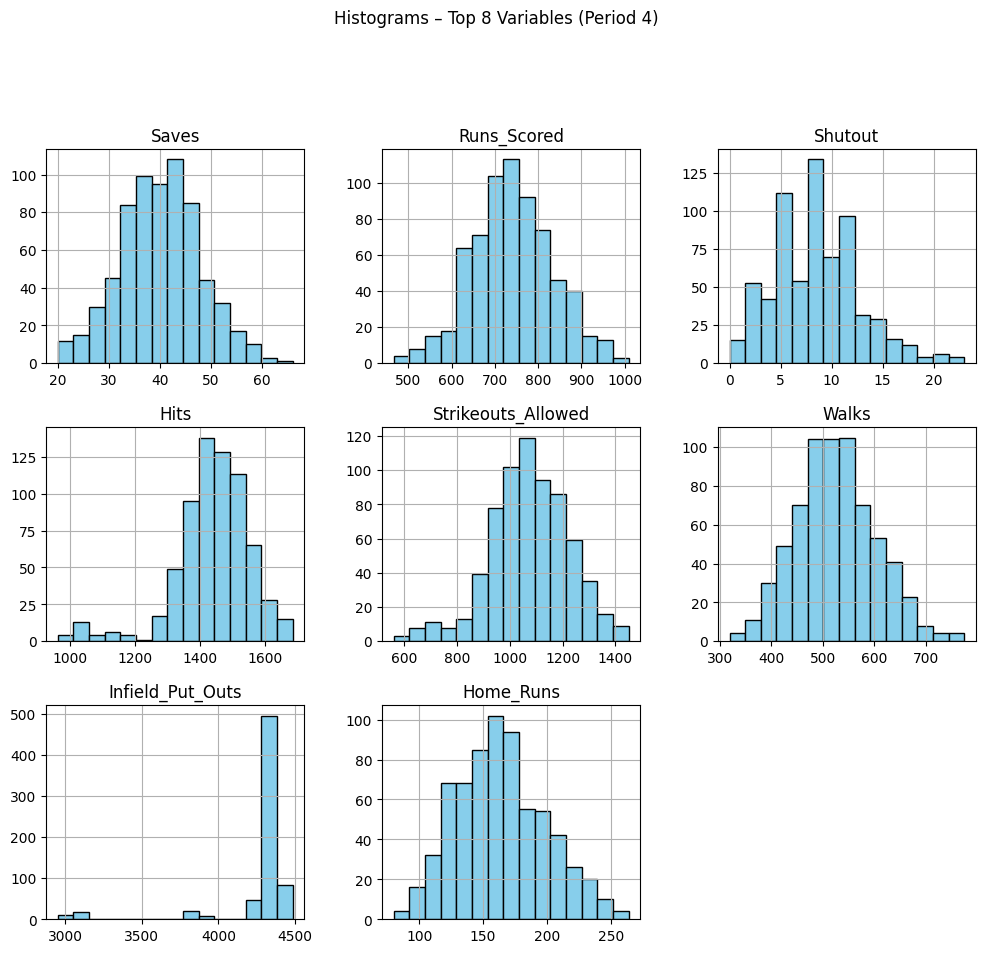

In [ ]:
period4[top8_vars_period_4.index].hist(bins=15, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle("Histograms – Top 8 Variables (Period 4)", y=1.02)
plt.show()

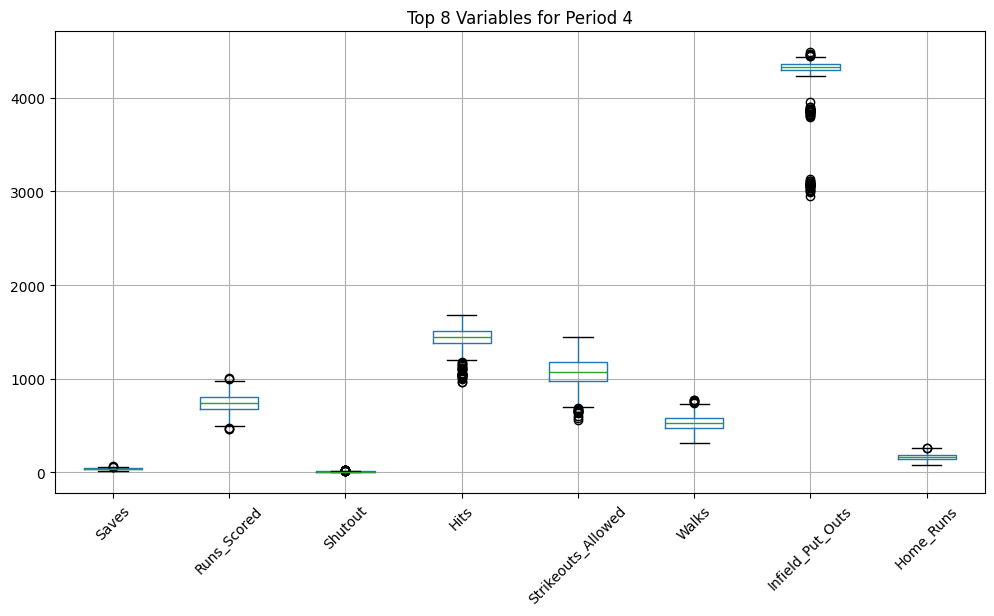

In [ ]:
plt.figure(figsize=(12,6))
period4[top8_vars_period_4.index].boxplot()
plt.title('Top 8 Variables for Period 4')
plt.xticks(rotation = 45)
plt.show()

Saves

The shape is fairly symmetric with a narrow spread, a single mode, and a few outliers

Runs Scored

The shape is slightly skewed to the right with a moderate spread, a single mode, and a lot of outliers of high value

Shutout

The shape is symmetric with a very narrow spread, a single mode, and a small amount of outliers  

Hits

the shape is symmetric with a wide spread, a single mode, and several outliers on both sides

Strikeouts Allowed

The shape is in between symmetric and slightly skewed to the right with a moderate spread, a single mode, and a few outliers on the lower side

Walks

The shape is slightly skewed to the right with a moderate spread, a single mode, and a few high value outliers

Infield put outs

The shape is fairly symmetric with a wide spread, a single mode, and a lot of outliers on the lower side

Home Runs

The shape is slightly skewed to the right with a narrow spread, a single mode, and several outliers on the higher end

Linear Regression Model

In [ ]:
x = period4[top8_vars_period_4.index]
y = period4['Games_Won']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [ ]:
x_train_constant = sm.add_constant(x_train)
ols_model = sm.OLS(y_train, x_train_constant)
ols_results = ols_model.fit()
display(ols_results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Games_Won   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     284.0
Date:                Wed, 19 Nov 2025   Prob (F-statistic):          5.15e-174
Time:                        16:45:07   Log-Likelihood:                -1439.6
No. Observations:                 476   AIC:                             2897.
Df Residuals:                     467   BIC:                             2935.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.7745      4.227      1.603      0.110      -1.532      15.082
Saves                  0.7092      0.035     20.222      0.000       0.640       0.778
Runs_Scored            0.0941      0.010      9.763      0.000       0.075       0.113
Shutout                0.8919      0.070     12.818      0.000       0.755       1.029
Hits                  -0.0188      0.007     -2.775      0.006      -0.032      -0.005
Strikeouts_Allowed     0.0191      0.002      8.248      0.000       0.015       0.024
Walks                  0.0027      0.005      0.546      0.586      -0.007       0.012
Infield_Put_Outs      -0.0056      0.002     -2.874      0.004      -0.009      -0.002
Home_Runs             -0.0242      0.011     -2.117      0.035      -0.047      -0.002
==============================================================================
Omnibus:                        2.062   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.855
Skew:                           0.141   Prob(JB):                        0.395
Kurtosis:                       3.118   Cond. No.                     8.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x_test_constant = sm.add_constant(x_test)
y_pred = ols_results.predict(x_test_constant)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
adj_r2 = ols_results.rsquared_adj
f_stat = ols_results.fvalue
p_value = ols_results.f_pvalue
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"Adjusted R-squared: {adj_r2}")
print(f"F-Statistic: {f_stat}")
print(f"P-value: {p_value}")

R-squared: 0.8467791981950853
RMSE: 5.018041390646309
Adjusted R-squared: 0.826564379755574
F-Statistic: 283.97105276771697
P-value: 5.148833096399652e-174


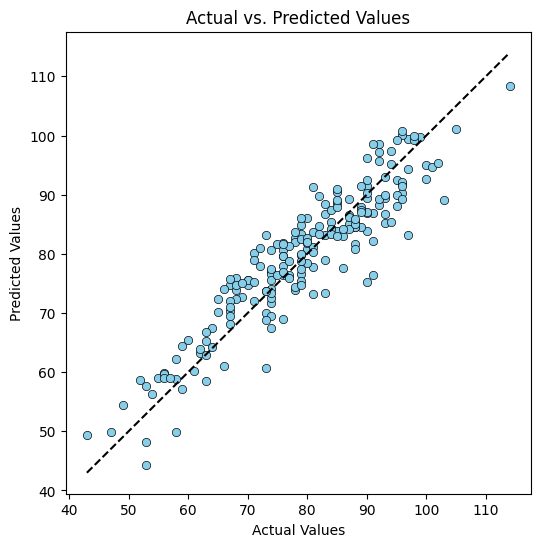

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, color='skyblue', edgecolor = 'black')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

Evaluation

R-Squared

84.7% of the variability in the dependent variable is explained by the model, this indicates a strong fit

Adjusted R-squared

Since the adjusted r-squared is only slightly lower than the regular r-squared, it indicates that the model is efficient

F-statistic

Since the F-value is 283.97, the p-value is < 0.001, meaning the model is highly significant

RMSE

Since the RMSE is around 5, due to the high range of values, the residual errors are reasonably tight. This means that the RMSE is consistent with a good predictive model

P-Value

The p-value is below the significance threshold. Therefore, the model is highlt significant

# Model Validation

Error Analysis

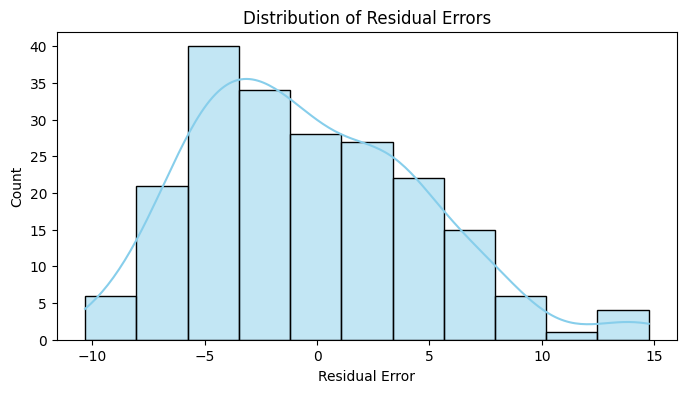

In [ ]:
errors = y_test - y_pred
plt.figure(figsize= (8,4))
sns.histplot(errors, kde = True, color = 'skyblue', edgecolor = 'black')
plt.title("Distribution of Residual Errors")
plt.xlabel("Residual Error")
plt.show()

Given that the models RMSE is 5.018, given the range is between 40-110, this represents a small and acceptable level of error. The residuals are centered near zero while being slightly skewed to the right. This indicates that the model is performing well

# Predictions

Wins for NY Yankees and Toronto Blue Jays

In [ ]:
teams_2012_2015 = df[
    (df['Team_Name'].isin(['New York Yankees', 'Toronto Blue Jays'])) &
    (df['Year'].isin([2012, 2015]))
][['Team_Name', 'Year'] + top8_vars_period_4.index.tolist() + ['Games_Won']]

In [ ]:
x_new = sm.add_constant(teams_2012_2015[top8_vars_period_4.index])
teams_2012_2015['Predicted_Games_Won'] = ols_results.predict(x_new)

In [ ]:
teams_2012_2015['Accuracy_%'] = 100 * (1 - (abs(teams_2012_2015['Games_Won'] -
                                                teams_2012_2015['Predicted_Games_Won']) / teams_2012_2015['Games_Won']))
display(teams_2012_2015)

,Team_Name,Year,Saves,Runs_Scored,Shutout,Hits,Strikeouts_Allowed,Walks,Infield_Put_Outs,Home_Runs,Games_Won,Predicted_Games_Won,Accuracy_%
2702,New York Yankees,2012,51,804,9,1462,1318,565,4336,245,95,95.669481,99.295283
2713,Toronto Blue Jays,2012,29,716,11,1346,1142,473,4331,198,73,73.314159,99.569645
2780,Toronto Blue Jays,2015,34,891,10,1480,1117,570,4323,232,93,88.923196,95.616339
2781,New York Yankees,2015,48,764,4,1397,1370,554,4373,212,87,88.092807,98.743900


Based on the model validation, we know that the predictions generated by the regression model closely match with the predicted model. This is further proven by predicting the number of wins for the New York Yankees and Toronto Blue Jays in 2012 and 2015. the model had sucessfully predicted that the Yankees would win 95 games and the Blue Jays would win 73 games in 2012. While in 2015, the model predicted that the Yankees and Blue Jays would both win 88 games, the Blue Jays won 87 and the Yankees won 93.

# Conclusions

In Conclusion, the project identified variables that strongly influenced the target outcome for each of the 4 time periods. The multiple regression model showed to be highly effective, explaining a substantial portion of variance with strong statistical significance. The Model demonstrated that prediction error was low (RMSE ≈ 5), while showing no major violations of assumptions. Finally, the predictions from the model closely matched actual outcomes, confirming the model's practical value. Overall, the analysis provides a clear, evidence-based understanding of which variables drive team performance and offers a reliable predictive framework that decision makers can use to determine areas of improvement and where to allocate resources.